In [1]:
## VIDEOACCESS V2

In [ ]:
# FIRST EDITED VERSION (WITHOUT KALMAN)

In [ ]:
# SEE BELOW FOR SECOND VERSION WITH KALMAN 

In [3]:
import cv2
import cv2 as cv
from matplotlib import pyplot as plt
import math
from math import atan2, cos, sin, sqrt, pi, degrees
import numpy as np

global center, radius, angle, thymio_detected

cap = cv2.VideoCapture(0)
count = 0

def get_thymio_position(img, kalman_center, kalman_angle, min_red = np.array([150, 0, 180]), max_red = np.array([179, 255, 255])):
    
    # RETURNS CENTER COORDINATES, RADIUS AND ORIENTATION (provides extra coordinants (xb, yb) to know which direction, as well as angle) OF THYMIO ROBOT

    
    img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    img_hsv_blur = cv2.medianBlur(img_hsv, 15)
    mask = cv2.inRange(img_hsv_blur, min_red, max_red)
    mask = cv2.erode(mask, None, iterations=2) # default 3x3 kernel used
    mask = cv2.dilate(mask, None, iterations=2)    
    output = cv2.bitwise_and(img, img, mask=mask)
    
    contours, hierarchy = cv2.findContours(mask, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE) # cv2.RETR_CCOMP lets us get contours inside parent contours
    contours = sorted(contours, key=lambda x:cv2.contourArea(x), reverse=True)
    
    thymio_detected = False
    center = kalman_center
    radius = 0
    angle = kalman_angle
    
    if len(contours) != 0:

        # find the biggest countour c by the area
        c = max(contours, key = cv2.contourArea)
        if cv.contourArea(c) > 5000:
            thymio_detected = True     

            # Minimum Enclosing Circle :
            (x_circle,y_circle),radius = cv.minEnclosingCircle(c)
            center = (int(x_circle),int(y_circle))
            radius = int(radius)
            cv.circle(output,center,radius,(0,255,0),10) 
            
            # Detection of front of thymio :
            for contour in contours:
                area = cv.contourArea(contour)
                if area > 2400 and area < 3200:
                    cv2.drawContours(output ,[contour],-1,(255,255,0),10)
                    (x_front,y_front),radius_front = cv.minEnclosingCircle(contour)
                    center_front = (int(x_front),int(y_front))
                    radius_front = int(radius_front)
                    cv.circle(output,center_front,radius_front,(255,255,0),10)
                    
                    angle = int(degrees(atan2(center_front[1]-center[1],center_front[0]-center[0]))) 
        
            
    #plt.imshow(output)
        
    return center, radius, angle, thymio_detected




# Check if the webcam is opened correctly
if not cap.isOpened():
    raise IOError("Cannot open webcam")

while True:
    ret, frame = cap.read()
    frame = cv2.resize(frame, None, fx=1, fy=1, interpolation=cv2.INTER_AREA)
    cv2.imshow('Input', frame)
    thymioLoc, thymioRadius, thymioAngle, thymioDetected = get_thymio_position(frame, (0,0), 0)
    
    cv2.circle(frame, (x, y), radius, (B,G,R), thickness)

    c = cv2.waitKey(1)
    count = count +1
    print(count)
    print('Center of Circle:',thymioLoc, '  Angle:',thymioAngle, '  Thymio Detected:' ,thymioDetected)
    if c == 27:
        break

cap.release()
cv2.destroyAllWindows()

1
Center of Circle: (0, 0)   Angle: 0   Thymio Detected: False
2
Center of Circle: (0, 0)   Angle: 0   Thymio Detected: False
3
Center of Circle: (0, 0)   Angle: 0   Thymio Detected: False
4
Center of Circle: (0, 0)   Angle: 0   Thymio Detected: False
5
Center of Circle: (0, 0)   Angle: 0   Thymio Detected: False
6
Center of Circle: (0, 0)   Angle: 0   Thymio Detected: False
7
Center of Circle: (0, 0)   Angle: 0   Thymio Detected: False
8
Center of Circle: (0, 0)   Angle: 0   Thymio Detected: False
9
Center of Circle: (0, 0)   Angle: 0   Thymio Detected: False
10
Center of Circle: (0, 0)   Angle: 0   Thymio Detected: False
11
Center of Circle: (0, 0)   Angle: 0   Thymio Detected: False
12
Center of Circle: (0, 0)   Angle: 0   Thymio Detected: False
13
Center of Circle: (0, 0)   Angle: 0   Thymio Detected: False
14
Center of Circle: (0, 0)   Angle: 0   Thymio Detected: False
15
Center of Circle: (0, 0)   Angle: 0   Thymio Detected: False
16
Center of Circle: (0, 0)   Angle: 0   Thymio D

126
Center of Circle: (326, 338)   Angle: 0   Thymio Detected: True
127
Center of Circle: (328, 336)   Angle: 0   Thymio Detected: True
128
Center of Circle: (336, 334)   Angle: 0   Thymio Detected: True
129
Center of Circle: (335, 337)   Angle: 0   Thymio Detected: True
130
Center of Circle: (338, 336)   Angle: 0   Thymio Detected: True
131
Center of Circle: (339, 336)   Angle: 0   Thymio Detected: True
132
Center of Circle: (342, 335)   Angle: 0   Thymio Detected: True
133
Center of Circle: (340, 336)   Angle: 0   Thymio Detected: True
134
Center of Circle: (340, 333)   Angle: 0   Thymio Detected: True
135
Center of Circle: (340, 335)   Angle: 0   Thymio Detected: True
136
Center of Circle: (340, 335)   Angle: 0   Thymio Detected: True
137
Center of Circle: (339, 337)   Angle: 0   Thymio Detected: True
138
Center of Circle: (339, 336)   Angle: 0   Thymio Detected: True
139
Center of Circle: (339, 335)   Angle: 0   Thymio Detected: True
140
Center of Circle: (340, 335)   Angle: 0   Th

248
Center of Circle: (812, 468)   Angle: 0   Thymio Detected: True
249
Center of Circle: (815, 467)   Angle: 0   Thymio Detected: True
250
Center of Circle: (815, 468)   Angle: 0   Thymio Detected: True
251
Center of Circle: (812, 467)   Angle: 0   Thymio Detected: True
252
Center of Circle: (818, 470)   Angle: 0   Thymio Detected: True
253
Center of Circle: (818, 466)   Angle: 0   Thymio Detected: True
254
Center of Circle: (814, 459)   Angle: 0   Thymio Detected: True
255
Center of Circle: (779, 445)   Angle: 0   Thymio Detected: True
256
Center of Circle: (765, 448)   Angle: 0   Thymio Detected: True
257
Center of Circle: (767, 450)   Angle: 0   Thymio Detected: True
258
Center of Circle: (768, 452)   Angle: 0   Thymio Detected: True
259
Center of Circle: (767, 451)   Angle: 0   Thymio Detected: True
260
Center of Circle: (770, 456)   Angle: 0   Thymio Detected: True
261
Center of Circle: (771, 457)   Angle: 0   Thymio Detected: True
262
Center of Circle: (768, 457)   Angle: 0   Th

372
Center of Circle: (0, 0)   Angle: 0   Thymio Detected: False
373
Center of Circle: (0, 0)   Angle: 0   Thymio Detected: False
374
Center of Circle: (0, 0)   Angle: 0   Thymio Detected: False
375
Center of Circle: (469, 513)   Angle: 0   Thymio Detected: True
376
Center of Circle: (0, 0)   Angle: 0   Thymio Detected: False
377
Center of Circle: (0, 0)   Angle: 0   Thymio Detected: False
378
Center of Circle: (0, 0)   Angle: 0   Thymio Detected: False
379
Center of Circle: (0, 0)   Angle: 0   Thymio Detected: False
380
Center of Circle: (470, 512)   Angle: 0   Thymio Detected: True
381
Center of Circle: (0, 0)   Angle: 0   Thymio Detected: False
382
Center of Circle: (0, 0)   Angle: 0   Thymio Detected: False
383
Center of Circle: (507, 458)   Angle: 0   Thymio Detected: True
384
Center of Circle: (557, 441)   Angle: 0   Thymio Detected: True
385
Center of Circle: (0, 0)   Angle: 0   Thymio Detected: False
386
Center of Circle: (615, 464)   Angle: 0   Thymio Detected: True
387
Center

498
Center of Circle: (0, 0)   Angle: 0   Thymio Detected: False
499
Center of Circle: (0, 0)   Angle: 0   Thymio Detected: False
500
Center of Circle: (0, 0)   Angle: 0   Thymio Detected: False
501
Center of Circle: (0, 0)   Angle: 0   Thymio Detected: False
502
Center of Circle: (0, 0)   Angle: 0   Thymio Detected: False
503
Center of Circle: (0, 0)   Angle: 0   Thymio Detected: False
504
Center of Circle: (0, 0)   Angle: 0   Thymio Detected: False
505
Center of Circle: (0, 0)   Angle: 0   Thymio Detected: False
506
Center of Circle: (0, 0)   Angle: 0   Thymio Detected: False
507
Center of Circle: (0, 0)   Angle: 0   Thymio Detected: False
508
Center of Circle: (0, 0)   Angle: 0   Thymio Detected: False
509
Center of Circle: (0, 0)   Angle: 0   Thymio Detected: False
510
Center of Circle: (0, 0)   Angle: 0   Thymio Detected: False
511
Center of Circle: (0, 0)   Angle: 0   Thymio Detected: False
512
Center of Circle: (654, 565)   Angle: 0   Thymio Detected: True
513
Center of Circle: 

622
Center of Circle: (0, 0)   Angle: 0   Thymio Detected: False
623
Center of Circle: (0, 0)   Angle: 0   Thymio Detected: False
624
Center of Circle: (0, 0)   Angle: 0   Thymio Detected: False
625
Center of Circle: (0, 0)   Angle: 0   Thymio Detected: False
626
Center of Circle: (0, 0)   Angle: 0   Thymio Detected: False
627
Center of Circle: (0, 0)   Angle: 0   Thymio Detected: False
628
Center of Circle: (0, 0)   Angle: 0   Thymio Detected: False
629
Center of Circle: (0, 0)   Angle: 0   Thymio Detected: False
630
Center of Circle: (0, 0)   Angle: 0   Thymio Detected: False
631
Center of Circle: (0, 0)   Angle: 0   Thymio Detected: False
632
Center of Circle: (0, 0)   Angle: 0   Thymio Detected: False
633
Center of Circle: (0, 0)   Angle: 0   Thymio Detected: False
634
Center of Circle: (0, 0)   Angle: 0   Thymio Detected: False
635
Center of Circle: (0, 0)   Angle: 0   Thymio Detected: False
636
Center of Circle: (0, 0)   Angle: 0   Thymio Detected: False
637
Center of Circle: (0,

KeyboardInterrupt: 

In [ ]:
## EDITED VERSION OF VIDEOACCES WITH KALMAN

In [27]:
import numpy as np

# Comments describing Kalman Filter taken from https://stackoverflow.com/questions/74318200/how-to-tune-extended-kalman-filter-on-pykalman

# Example of instance: KF=KalmanFilter(0.03333, [0, 0, 0, 0, 0]) (Ts is time between each measurement, x_ini is initial conditions)

# For update() function : takes as input the measurement vector z
# z[0:2] are the measurements from the camera (px, py, orientation)
# z[3:4] are the measurements from the Thymio (forward speed v and angular speed omega)


class KalmanFilter():
    def __init__(self, Ts, x_ini):
        self.Ts = Ts

        # Initial State Vector
        self.x=np.matrix([[x_ini[0]], [x_ini[1]], [x_ini[2]], [x_ini[3]], [x_ini[4]]])
    

        # State Transition Matrix (Warning : changes with time -> Extended Kalman Filter)
        self.Fk=np.matrix([[1, 0, 0, 0, 0],
                           [0, 1, 0, 0, 0],
                           [0, 0, 1, 0, 0],
                           [0, 0, 0, 1, 0],
                           [0, 0, 0, 0, 1]])

        # Measurement matrix H (here by default, we consider all states px, py, theta, v, omega can be observed)
        # Used to convert the predicted state estimate into predicted sensor measurements at time k.
        # In this case, H will be the identity matrix since the estimated state maps directly to state measurements data
        # H has the same number of rows as sensor measurements and same number of columns as states.
        self.H=np.matrix([[1, 0, 0, 0, 0],
                          [0, 1, 0, 0, 0],
                          [0, 0, 1, 0, 0],
                          [0, 0, 0, 1, 0],
                          [0, 0, 0, 0, 1]])

        
        # State model noise covariance matrix Q
        # When Q is large, the Kalman Filter tracks large changes in
        # the sensor measurements more closely than for smaller Q.
        # Q is a square matrix that has the same number of rows as states.
        self.Q=np.matrix([[0.01, 0, 0, 0, 0],
                          [0, 0.01, 0, 0, 0],
                          [0, 0, 0.01, 0, 0],
                          [0, 0, 0, 0.01, 0],
                          [0, 0, 0, 0, 0.01]]) 

        # Sensor measurement noise covariance matrix R
        # Has the same number of rows and columns as sensor measurements.
        # If we are sure about the measurements, R will be near zero.
        self.R=np.matrix([[0.001, 0, 0, 0, 0],
                          [0, 0.001, 0, 0, 0],
                          [0, 0, 0.001, 0, 0],
                          [0, 0, 0, 0.5, 0],
                          [0, 0, 0, 0, 0.5]])

        self.P=np.matrix([[1, 0, 0, 0, 0],
                           [0, 1, 0, 0, 0],
                           [0, 0, 1, 0, 0],
                           [0, 0, 0, 1, 0],
                           [0, 0, 0, 0, 1]])
        
    def updateFk(self):
        self.Fk=np.matrix([[1, 0, -self.Ts*self.x[3]*np.sin(self.x[2]), self.Ts*np.cos(self.x[2]), 0],
                      [0, 1,  self.Ts*self.x[3]*np.cos(self.x[2]), self.Ts*np.sin(self.x[2]), 0],
                      [0, 0, 1, 0, self.Ts],
                      [0, 0, 0, 1, 0],
                      [0, 0, 0, 0, 1]])
        self.Fk = self.Fk.astype(float)

    def predict(self):
        # Update Fk
        self.updateFk()
        # Predict the state estimate (A Priori) at time k based on the state estimate at time k-1
        self.x=np.dot(self.Fk, self.x)
        # Predict the state covariance estimate based on the previous covariance and some noise
        self.P=np.dot(np.dot(self.Fk, self.P), self.Fk.T)+self.Q
        return self.x

    def update(self, z, CameraAccessible = True): # z[0:2] corrpesonds to measurement of camera, z[3:4] corresponds to measurements of wheels
        
        if CameraAccessible:
            self.H=np.matrix([[1, 0, 0, 0, 0],
                          [0, 1, 0, 0, 0],
                          [0, 0, 1, 0, 0],
                          [0, 0, 0, 1, 0],
                          [0, 0, 0, 0, 1]])
            
            self.R=np.matrix([[0.001, 0, 0, 0, 0],
                          [0, 0.001, 0, 0, 0],
                          [0, 0, 0.001, 0, 0],
                          [0, 0, 0, 0.5, 0],
                          [0, 0, 0, 0, 0.5]])
        else: # CAUTION : IF CAMERAACCESSIBLE = FALSE, Z IS A 2x1 VECTOR
            # Measurement matrix H (now only v and omega can be observed)
            self.H=np.matrix([[0, 0, 0, 1, 0],
                              [0, 0, 0, 0, 1]])
            
            self.R=np.matrix([[0.5, 0],
                              [0,0.5]])
            
            
        # Compute Kalman gain
        S=np.dot(self.H, np.dot(self.P, self.H.T))+self.R
        inv_S = np.linalg.pinv(S.astype(float))
        K=np.dot(np.dot(self.P, self.H.T),inv_S)

        # Correction / innovation
        # Calculate an updated state estimate (A Posteriori) for time k
        self.x=self.x+np.dot(K, (z-np.dot(self.H, self.x)))
        self.x=np.round(self.x.astype(float))
        # Update the state covariance estimate for time k
        I=np.eye(self.H.shape[1])
        self.P=(I-(K*self.H))*self.P


        return self.x

In [28]:
KF=KalmanFilter(0.03333, [0, 0, 0, 0, 0])

fps: 30
Estimated States:
 [[ 1.]
 [ 0.]
 [-0.]
 [33.]
 [-0.]]
1
Center of Circle: (0, 0)   Angle: 0   Thymio Detected: False
Estimated States:
 [[218.]
 [409.]
 [  0.]
 [ 22.]
 [ -3.]]
2
Center of Circle: (218, 409)   Angle: 0   Thymio Detected: True
Estimated States:
 [[219.]
 [408.]
 [ -0.]
 [ 16.]
 [ -2.]]
3
Center of Circle: (219, 408)   Angle: 0   Thymio Detected: True
Estimated States:
 [[220.]
 [412.]
 [  0.]
 [ 12.]
 [ -2.]]
4
Center of Circle: (220, 412)   Angle: 0   Thymio Detected: True
Estimated States:
 [[227.]
 [416.]
 [  0.]
 [ 12.]
 [ -2.]]
5
Center of Circle: (228, 416)   Angle: 0   Thymio Detected: True
Estimated States:
 [[229.]
 [419.]
 [  0.]
 [ 10.]
 [ -2.]]
6
Center of Circle: (229, 419)   Angle: 0   Thymio Detected: True
Estimated States:
 [[227.]
 [413.]
 [ -0.]
 [  8.]
 [ -2.]]
7
Center of Circle: (227, 412)   Angle: 0   Thymio Detected: True
Estimated States:
 [[224.]
 [419.]
 [  0.]
 [  6.]
 [ -2.]]
8
Center of Circle: (224, 420)   Angle: 0   Thymio Detecte

Estimated States:
 [[184.]
 [270.]
 [ -0.]
 [ 46.]
 [ -2.]]
67
Center of Circle: (0, 0)   Angle: 0   Thymio Detected: False
Estimated States:
 [[186.]
 [270.]
 [ -0.]
 [ 47.]
 [ -2.]]
68
Center of Circle: (0, 0)   Angle: 0   Thymio Detected: False
Estimated States:
 [[188.]
 [270.]
 [ -0.]
 [ 47.]
 [ -2.]]
69
Center of Circle: (0, 0)   Angle: 0   Thymio Detected: False
Estimated States:
 [[190.]
 [270.]
 [ -0.]
 [ 47.]
 [ -2.]]
70
Center of Circle: (0, 0)   Angle: 0   Thymio Detected: False
Estimated States:
 [[192.]
 [270.]
 [ -0.]
 [ 47.]
 [ -2.]]
71
Center of Circle: (0, 0)   Angle: 0   Thymio Detected: False
Estimated States:
 [[194.]
 [270.]
 [ -0.]
 [ 47.]
 [ -2.]]
72
Center of Circle: (0, 0)   Angle: 0   Thymio Detected: False
Estimated States:
 [[196.]
 [270.]
 [ -0.]
 [ 47.]
 [ -2.]]
73
Center of Circle: (0, 0)   Angle: 0   Thymio Detected: False
Estimated States:
 [[198.]
 [270.]
 [ -0.]
 [ 47.]
 [ -2.]]
74
Center of Circle: (0, 0)   Angle: 0   Thymio Detected: False
Estimate

Estimated States:
 [[320.]
 [328.]
 [ -0.]
 [ 47.]
 [ -2.]]
135
Center of Circle: (0, 0)   Angle: 0   Thymio Detected: False
Estimated States:
 [[322.]
 [329.]
 [ -0.]
 [ 47.]
 [ -2.]]
136
Center of Circle: (0, 0)   Angle: 0   Thymio Detected: False
Estimated States:
 [[324.]
 [330.]
 [ -0.]
 [ 47.]
 [ -2.]]
137
Center of Circle: (0, 0)   Angle: 0   Thymio Detected: False
Estimated States:
 [[326.]
 [331.]
 [ -0.]
 [ 47.]
 [ -2.]]
138
Center of Circle: (0, 0)   Angle: 0   Thymio Detected: False
Estimated States:
 [[328.]
 [332.]
 [ -0.]
 [ 47.]
 [ -2.]]
139
Center of Circle: (0, 0)   Angle: 0   Thymio Detected: False
Estimated States:
 [[330.]
 [333.]
 [ -0.]
 [ 47.]
 [ -2.]]
140
Center of Circle: (0, 0)   Angle: 0   Thymio Detected: False
Estimated States:
 [[332.]
 [334.]
 [ -0.]
 [ 47.]
 [ -2.]]
141
Center of Circle: (0, 0)   Angle: 0   Thymio Detected: False
Estimated States:
 [[334.]
 [335.]
 [ -0.]
 [ 47.]
 [ -2.]]
142
Center of Circle: (0, 0)   Angle: 0   Thymio Detected: False


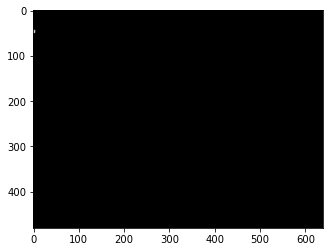

In [29]:
# https://www.geeksforgeeks.org/live-webcam-drawing-using-opencv/

import cv2
import cv2 as cv
from matplotlib import pyplot as plt
import math
from math import atan2, cos, sin, sqrt, pi, degrees
import numpy as np


global center, radius, angle, thymio_detected



# set Width and Height of output Screen
frameWidth = 640
frameHeight = 480
  
# capturing Video from Webcam
cap = cv2.VideoCapture(0)
cap.set(3, frameWidth)
cap.set(4, frameHeight)

# set fps : https://stackoverflow.com/questions/52068277/change-frame-rate-in-opencv-3-4-2
# here does not work
# cap.set(cv2.CAP_PROP_FPS, 10)
fps = int(cap.get(5))
print("fps:", fps)
  
# set brightness, id is 10 and
# value can be changed accordingly
cap.set(10,150)





def get_thymio_position(img, img_output, kalman_center, kalman_angle, min_red = np.array([150, 0, 180]), max_red = np.array([179, 255, 255])):
    
    # RETURNS CENTER COORDINATES, RADIUS AND ORIENTATION (provides extra coordinants (xb, yb) to know which direction, as well as angle) OF THYMIO ROBOT

    
    img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    img_hsv_blur = cv2.medianBlur(img_hsv, 15)
    mask = cv2.inRange(img_hsv_blur, min_red, max_red)
    mask = cv2.erode(mask, None, iterations=2) # default 3x3 kernel used
    mask = cv2.dilate(mask, None, iterations=2)    
    output = cv2.bitwise_and(img, img, mask=mask)
    
    contours, hierarchy = cv2.findContours(mask, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE) # cv2.RETR_CCOMP lets us get contours inside parent contours
    contours = sorted(contours, key=lambda x:cv2.contourArea(x), reverse=True)
    
    thymio_detected = False
    center = kalman_center
    radius = 0
    angle = kalman_angle
    
    if len(contours) != 0:

        # find the biggest countour c by the area
        c = max(contours, key = cv2.contourArea)
        if cv.contourArea(c) > 5000:
            thymio_detected = True     

            # Minimum Enclosing Circle :
            (x_circle,y_circle),radius = cv.minEnclosingCircle(c)
            center = (int(x_circle),int(y_circle))
            radius = int(radius)
            cv.circle(output,center,radius,(0,255,0),10)
            cv2.circle(img_output, center, radius, (0,0,255), 10)
            
            # Detection of front of thymio :
            for contour in contours:
                area = cv.contourArea(contour)
                if area > cv2.contourArea(c)/10 and area < cv2.contourArea(c)/10+2000:
                    cv2.drawContours(output ,[contour],-1,(255,255,0),10)
                    (x_front,y_front),radius_front = cv.minEnclosingCircle(contour)
                    center_front = (int(x_front),int(y_front))
                    radius_front = int(radius_front)
                    cv.circle(output,center_front,radius_front,(255,255,0),10)
                    cv2.circle(img_output, center_front, radius_front, (0,255,255), 10)
                    
                    angle = int(degrees(atan2(center_front[1]-center[1],center_front[0]-center[0]))) 
        
            
    plt.imshow(output)
        
    return center, radius, angle, thymio_detected











count = 0

# Check if the webcam is opened correctly
if not cap.isOpened():
    raise IOError("Cannot open webcam")

# running infinite while loop so that
# program keep running until we close it
while True:
    success, img = cap.read()
    imgResult = img.copy()
    
    thymioLoc, thymioRadius, thymioAngle, thymioDetected = get_thymio_position(img, imgResult, (0,0), 0)
    
    
    # KALMAN -------------------------------------------------------------------
    KF.predict()
    if thymioDetected:
        z = np.array([thymioLoc[0],thymioLoc[1],0,0, 0])
        z = np.expand_dims(z, axis=-1)
    else:
        z = np.array([50, -0.1])
        z = np.expand_dims(z, axis=-1)
    KF.update(z,thymioDetected)
    cv2.circle(imgResult, (int(KF.x[0]), int(KF.x[1])), 10, (255,0,255), 10)
    print('Estimated States:\n',KF.x)
    # KALMAN ----------------------------------------------------------------------
    
    count = count +1
    print(count)
    print('Center of Circle:',thymioLoc, '  Angle:',thymioAngle, '  Thymio Detected:' ,thymioDetected)
 

    # displaying output on Screen
    cv2.imshow("Result", imgResult)
    
    c = cv2.waitKey(1)
    if c == 27:
        break
      
